In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels

Epoch 1/100
180/180 - 7s - loss: 0.0764 - 7s/epoch - 36ms/step
Epoch 2/100
180/180 - 4s - loss: 0.0722 - 4s/epoch - 21ms/step
Epoch 3/100
180/180 - 3s - loss: 0.0724 - 3s/epoch - 16ms/step
Epoch 4/100
180/180 - 2s - loss: 0.0703 - 2s/epoch - 13ms/step
Epoch 5/100
180/180 - 2s - loss: 0.0701 - 2s/epoch - 13ms/step
Epoch 6/100
180/180 - 2s - loss: 0.0699 - 2s/epoch - 14ms/step
Epoch 7/100
180/180 - 4s - loss: 0.0715 - 4s/epoch - 20ms/step
Epoch 8/100
180/180 - 5s - loss: 0.0697 - 5s/epoch - 28ms/step
Epoch 9/100
180/180 - 4s - loss: 0.0711 - 4s/epoch - 24ms/step
Epoch 10/100
180/180 - 6s - loss: 0.0695 - 6s/epoch - 32ms/step
Epoch 11/100
180/180 - 5s - loss: 0.0681 - 5s/epoch - 26ms/step
Epoch 12/100
180/180 - 5s - loss: 0.0704 - 5s/epoch - 26ms/step
Epoch 13/100
180/180 - 3s - loss: 0.0671 - 3s/epoch - 19ms/step
Epoch 14/100
180/180 - 3s - loss: 0.0686 - 3s/epoch - 18ms/step
Epoch 15/100
180/180 - 2s - loss: 0.0687 - 2s/epoch - 13ms/step
Epoch 16/100
180/180 - 2s - loss: 0.0691 - 2s/epo

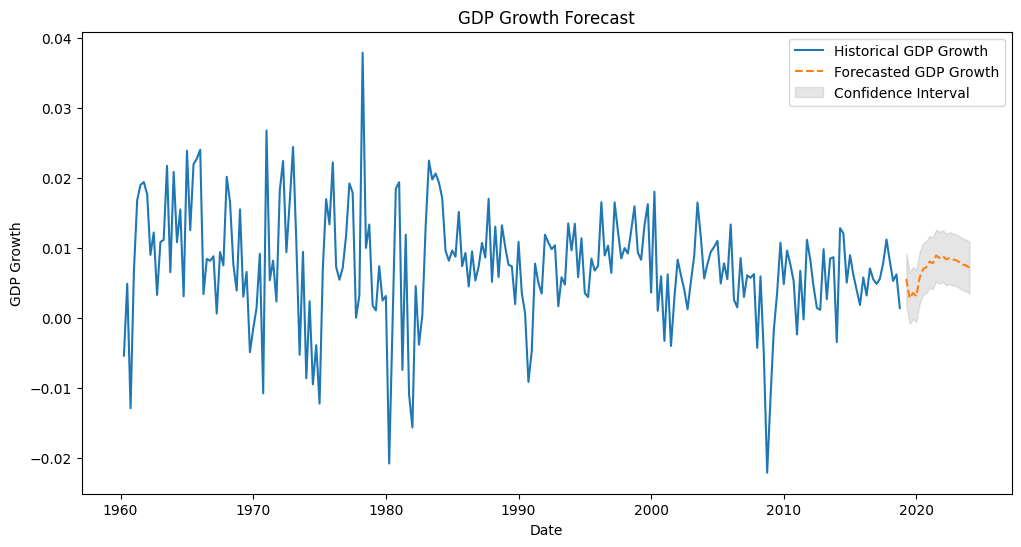


MAE: 0.004723759253896655
MAPE: 210.0756541545659
Theil U: 0.8817888335521668
Bias Proportion: 0.2700877510703282
Variance Proportion: 0.9725942653280214
Covariance Proportion: nan
Symmetric MAPE: 3072.3341063637054
RMSE (Test): 0.00605627496996276


<ipython-input-2-0cebb7985c45>:142: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(y_true, y_pred)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [2]:
# Importar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Cargar data de CSV proveniente de eViews
data = pd.read_csv('DataDIFLOG.csv')

# Quitar columnas extras en este caso inflation y unemployment
data.drop(columns=['Inflation', 'Unemployment'], inplace=True)

# Cambiar la columna de "Date" a datetime y poner como indice
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Llenar valores restantes (porsia)
data = data.fillna(method='ffill').fillna(method='bfill')

# Preprocesar la data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

# Dividir la data entre set de entrenamiento y testeo
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Crear los datasets para LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 8  # Esta es la cantidad de periodos anteriores que se usaran para las predicciones
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Armar y entrenar el modelo!
model = Sequential()
model.add(LSTM(113, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(113))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Las predicciones!
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir predicciones a la escala original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Asegurarse de que "y_train" y "y_test" sean 2-d antes de la transformacion inversa
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Calcular RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
print('Train RMSE: %.2f' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('Test RMSE: %.2f' % (test_rmse))

# Ahora predecimos los valores futuros
def forecast(model, data, n_steps):
    predictions = []
    current_step = data[-look_back:]
    for _ in range(n_steps):
        current_step = current_step.reshape((1, look_back, 1))
        pred = model.predict(current_step, verbose=0)
        predictions.append(pred[0, 0])
        current_step = np.append(current_step[:, 1:, :], [[pred[0]]], axis=1)
    return np.array(predictions)

# Prediccion desde Q12019 hasta Q42023 (20 trimestres en total)
future_steps = 20
future_forecast = forecast(model, scaled_data, future_steps)

# Invertir la prediccion a escala original
future_forecast = scaler.inverse_transform(future_forecast.reshape(-1, 1))

# Crear rango de datos para futuras predicciones
future_dates = pd.date_range(start='2019-01-01', periods=future_steps, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['GDP'])

# Print los valores de GDP predecidos por trimestre
print("\nForecasted GDP Growth per Quarter:")
for date, gdp in future_df.itertuples():
    print(f"{date}: {gdp}")

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical GDP Growth')
plt.plot(future_df, label='Forecasted GDP Growth', linestyle='--')

# Calcular el error estandar para hacer el intervalo de confianza
predictions_std = np.std(future_forecast)
conf_int_upper = future_forecast.flatten() + 2 * predictions_std
conf_int_lower = future_forecast.flatten() - 2 * predictions_std

# Confidence interval (2 standard errors)
plt.fill_between(future_df.index, conf_int_lower, conf_int_upper, color='gray', alpha=0.2, label='Confidence Interval')

plt.title('GDP Growth Forecast')
plt.xlabel('Date')
plt.ylabel('GDP Growth')
plt.legend()
plt.show()

# Aca hacemos las pruebas
def theil_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.sum((y_pred - y_true)**2) / np.sum(y_true**2))

def bias_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_pred - y_true) / np.mean(y_true)

def variance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.var(y_pred) / np.var(y_true)

def covariance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1]
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        return np.nan
    return covariance / (std_true * std_pred)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator[denominator != 0])

mae = mean_absolute_error(y_test, test_predict)
mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
theil_u_stat = theil_u(y_test, test_predict)
bias = bias_proportion(y_test, test_predict)
variance = variance_proportion(y_test, test_predict)
covariance = covariance_proportion(y_test, test_predict)
smape_value = smape(y_test, test_predict)

print(f'\nMAE: {mae}')
print(f'MAPE: {mape}')
print(f'Theil U: {theil_u_stat}')
print(f'Bias Proportion: {bias}')
print(f'Variance Proportion: {variance}')
print(f'Covariance Proportion: {covariance}')
print(f'Symmetric MAPE: {smape_value}')
print(f'RMSE (Test): {test_rmse}')

In [3]:
# Aca hacemos las pruebas
def theil_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.sum((y_pred - y_true)**2) / np.sum(y_true**2))

def bias_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_pred - y_true) / np.mean(y_true)

def variance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.var(y_pred) / np.var(y_true)

def covariance_proportion(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan
    covariance = np.cov(y_true, y_pred)[0, 1]
    std_true = np.std(y_true)
    std_pred = np.std(y_pred)
    if std_true == 0 or std_pred == 0:
        return np.nan
    return covariance / (std_true * std_pred)

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / denominator[denominator != 0])

mae = mean_absolute_error(y_test, test_predict)
mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
theil_u_stat = theil_u(y_test, test_predict)
bias = bias_proportion(y_test, test_predict)
variance = variance_proportion(y_test, test_predict)
covariance = covariance_proportion(y_test, test_predict)
smape_value = smape(y_test, test_predict)

print(f'\nMAE: {mae}')
print(f'MAPE: {mape}')
print(f'Theil U: {theil_u_stat}')
print(f'Bias Proportion: {bias}')
print(f'Variance Proportion: {variance}')
print(f'Covariance Proportion: {covariance}')
print(f'Symmetric MAPE: {smape_value}')
print(f'RMSE (Test): {test_rmse}')


MAE: 0.004723759253896655
MAPE: 210.0756541545659
Theil U: 0.8817888335521668
Bias Proportion: 0.2700877510703282
Variance Proportion: 0.9725942653280214
Covariance Proportion: nan
Symmetric MAPE: 3072.3341063637054
RMSE (Test): 0.00605627496996276


<ipython-input-3-09a08c852355>:18: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(y_true, y_pred)[0, 1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
